In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 
from sklearn.cluster import KMeans
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.decomposition import PCA
from scipy.spatial import distance_matrix
from sklearn import preprocessing
from collections import deque

In [2]:
def BFS(adj, n):    
    u = 0
    visited = [False for i in range(n + 1)]
    distance = [-1 for i in range(n + 1)]
    distance[u] = 0
    queue = deque()
    queue.append(u)
    visited[u] = True
    
    while queue:
        front = queue.popleft()
        for i in adj[front]:
            if not visited[i]:
                visited[i] = True
                distance[i] = distance[front] + 1
                queue.append(i)

    maxDis = 0
    for i in range(n + 1):
        if distance[i] > maxDis:
            maxDis = distance[i]
            nodeIdx = i
    
    path = []
    path = path + [nodeIdx]
    while nodeIdx != 0:
        for i in adj[nodeIdx]:
            if distance[i] == maxDis - 1:
                nodeIdx = i
                maxDis = maxDis - 1
                path = path + [i]
        
    return path

def longest_path(edges_mst):
    
    n = len(edges_mst)
    adj = [[] for i in range(n + 1)]
    for i in range(n):
        u = edges_mst[i][0]
        v = edges_mst[i][1]
        adj[u].append(v)
        adj[v].append(u)
    
    path = BFS(adj, n)
    path_set = set(path)
    edges_long = []
    for i in range(n):
        a = edges_mst[i][0] in path_set 
        b = edges_mst[i][1] in path_set
        if a and b:
            edges_long.append((edges_mst[i][0], edges_mst[i][1])) 
    
    return np.array(edges_long)

In [3]:
def create_tree(X, n_clusters='sqrt'):
    
    if n_clusters == 'sqrt':
        n_clusters = int( np.sqrt(X.shape[0] ) ) 

    clustering = KMeans(n_clusters = n_clusters, random_state = 0).fit(X)
    cluster_centers_ = clustering.cluster_centers_
    predicted_clusters = clustering.labels_

    cluster_centers_ = np.array(sorted(cluster_centers_, key=lambda x: (x[0],x[1])))
    mst = minimum_spanning_tree(distance_matrix(cluster_centers_,cluster_centers_))
    edges_mst = get_edges(mst)
    
    dict_result = {}
    
    dict_result['nodes_positions'] = cluster_centers_
    dict_result['edges_mst'] = get_edges(mst)
    dict_result['edges_long'] = longest_path(edges_mst)

    return dict_result

def get_edges(adj_mat):
    edges = []
    vertex_cnt = adj_mat.shape[0]
    for v1 in range(vertex_cnt):
        for v2 in range(v1, vertex_cnt):
            if (adj_mat[v1,v2] != 0) or (adj_mat[v2,v1] != 0):
                edges.append((v1,v2))
    return np.array(edges)

In [4]:
def plot_graph(edges, nodes_positions, data):
 
    plt.scatter(data[:,0], data[:,1], linewidth = 1, alpha = 0.3)
    plt.scatter(nodes_positions[:,0], nodes_positions[:,1], c = 'black', linewidth = 2)
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    edge_cnt = edges.shape[0]
    for k in range(edge_cnt):
        x = edges[k,0]
        y = edges[k,1]
        x_line = [ nodes_positions[x,0],  nodes_positions[y,0] ]
        y_line = [ nodes_positions[x,1],  nodes_positions[y,1] ]
        plt.plot(x_line, y_line, 'black', linewidth = 2)

In [23]:
def intersect(tot1, tot2, ab):
    # intersect between tot1-tot2 segment and ab point
    x1 = tot1[0]
    y1 = tot1[1]
    x2 = tot2[0]
    y2 = tot2[1]
    a = ab[0]
    b = ab[1]
    slope = (y2-y1)/(x2-x1)
    
    x = (slope*x1 + a/slope + b - y1)/(slope+1/slope)
    y = (-x1 + a + b*slope + y1/slope)/(slope+1/slope)
    return np.array([x,y])

def inside_check(tot1, tot2, ab):
    intr = intersect(tot1,tot2,ab)
    
    a = np.less_equal(tot1, intr).all
    b = np.less_equal(intr, tot2).all
    c = np.less_equal(tot2, intr).all
    d = np.less_equal(intr, tot1).all
    
    return (a and b) or (c and d)

def distance(tot1, tot2, ab):
    intr = intersect(tot1,tot2,ab)
    return np.linalg.norm(intr - ab)

def unit_vector(x, y):
    return (y-x) / np.linalg.norm(y - x)

def crossvec(x, y):
    cv = x[0]*y[1] - x[1]*y[0] 
    return cv

def crossvec_direction(tot1,tot2,ab):
    if crossvec(tot2-tot1, ab-tot1) >=0:
        return(1)
    else:
        return(-1)

In [53]:
def pseudotime(edges, nodes_positions, data):

    time_start = 0.0
    update_dist = np.full(data.shape[0], np.inf)
    update_time = np.full(data.shape[0], 0.0)
    update_updown = np.full(data.shape[0],0.0)
    
    pseudotime_flow = [0.0]
    for i in range(edges.shape[0]):
        
        point1 = nodes_positions[edges[i][0]]
        point2 = nodes_positions[edges[i][1]]
        dist_i = np.full(data.shape[0], 0.0)
        seg_dist = np.full(data.shape[0], np.inf)
        intersect_seg = []
        
        for j in range(data.shape[0]):
            dist_i[j] = np.linalg.norm(data[j] - point1)
            
            if inside_check(point1, point2, data[j]):
                seg_dist[j] = distance(point1, point2, data[j])
            intersect_seg.append(intersect(point1, point2, data[j]))
            
        seg_unit_vec = unit_vector(point1, point2)
        intersect_seg = np.array(intersect_seg)
        
        for j in range(data.shape[0]):
            if dist_i[j]<seg_dist[j] and dist_i[j]<update_dist[j]:
                update_time[j] = time_start
                update_dist[j] = dist_i[j]
                update_updown[j] = crossvec_direction(point1, point2, data[j])*dist_i[j]
            
            elif seg_dist[j]<update_dist[j]:
                relative_cordinates = seg_unit_vec.dot(np.subtract(intersect_seg[j], point1))
                update_time[j] = time_start + relative_cordinates
                update_dist[j] = seg_dist[j]
                update_updown[j] = crossvec_direction(point1, point2, data[j])*seg_dist[j]
        
        time_start += np.linalg.norm(point1 - point2)
        pseudotime_flow.append(time_start)
            
    i = 0
    start1 = nodes_positions[edges[i][0]]
    start2 = nodes_positions[edges[i][1]]
    dist_i = np.full(data.shape[0], 0.0)
    
    seg_unit_vec = unit_vector(start1, start2)
    
    for j in range(data.shape[0]):
        dist_i[j] = np.linalg.norm(data[j] - start1)
        if dist_i[j] <= update_dist[j]:
            
            intersect_point = intersect(start1,start2,data[j])
            relative_cordinates = 0.0 + seg_unit_vec.dot(np.subtract(intersect_point, start1))
            update_time[j] = relative_cordinates
            segment_dist = distance(start1, start2, data[j])
            update_updown[j] = crossvec_direction(start1, start2, data[j])*segment_dist 
    
    i = edges.shape[0] - 1
    end1 = nodes_positions[edges[i][0]]
    end2 = nodes_positions[edges[i][1]]
    dist_i = np.full(data.shape[0], 0.0)
    
    seg_unit_vec = unit_vector(end1, end2)
    
    for j in range(data.shape[0]):
        dist_i[j] = np.linalg.norm(data[j] - end2)
        if dist_i[j] <= update_dist[j]:
            
            intersect_point = intersect(end1,end2,data[j])
            relative_cordinates = time_start + seg_unit_vec.dot(np.subtract(intersect_point, end2))
            update_time[j] = relative_cordinates
            segment_dist = distance(end1, end2, data[j])
            update_updown[j] = crossvec_direction(end1, end2, data[j])*segment_dist 
    
    pseudotime = update_time
    pseudotime_y = update_updown
    pseudotime_flow = pseudotime_flow


    pseudotime_range = max(pseudotime)-min(pseudotime)
    
    pseudotime_flow = pseudotime_flow-min(pseudotime)
    pseudotime_flow = pseudotime_flow/pseudotime_range

    pseudotime = pseudotime-min(pseudotime)
    pseudotime = pseudotime/pseudotime_range
    
    plot_trajectory(pseudotime, pseudotime_flow, pseudotime_y)  

In [54]:
def plot_trajectory(pseudotime, pseudotime_flow, pseudotime_y):
    
    plt.scatter(pseudotime, pseudotime_y, linewidth = 1, alpha = 0.3)
    plt.scatter(pseudotime_flow, np.zeros(pseudotime_flow.shape[0]) , c = 'black', linewidth = 2)
    plt.xlabel('pseudotime_y')
    plt.ylabel('pseudotime')
    edge_cnt = pseudotime_flow.shape[0] - 1
    for k in range(edge_cnt):
        x1 = pseudotime_flow[k]
        x2 = pseudotime_flow[k+1]
        x_line = [ x1, x2]
        y_line = [ 0, 0]
        plt.plot(x_line, y_line, 'black', linewidth = 2)

## TPM data

In [55]:
df = pd.read_csv('mono_TPM.txt', sep = '\t', index_col = 0)
df = df.T
print(df.shape)
df.head()

(384, 23686)


,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A4GALT,A4GNT,AA06,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
SRR1032910,0.00,0.0,0.12,0.0,0.0,0.27,0.0,0.0,0.0,0.0,...,43.34,27.46,0.0,4.02,5.82,7.09,4.35,75.58,0.29,17.55
SRR1032911,7.76,0.0,0.46,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,189.86,296.33,0.0,0.00,48.06,6.11,20.02,267.65,0.71,7.30
SRR1032912,6.91,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,60.27,186.80,0.0,0.00,0.71,1.21,12.40,63.03,3.36,21.29
SRR1032913,0.00,0.0,0.74,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,78.87,204.53,0.0,0.00,2.51,6.40,11.56,347.76,2.08,4.70
SRR1032914,0.00,0.0,0.15,0.0,0.0,0.41,0.0,0.0,0.0,0.0,...,178.68,492.24,0.0,29.63,2.63,2.65,6.93,501.32,0.00,61.12


In [56]:
X = df.values
X = PCA().fit_transform(X)
X = X[:,:2]

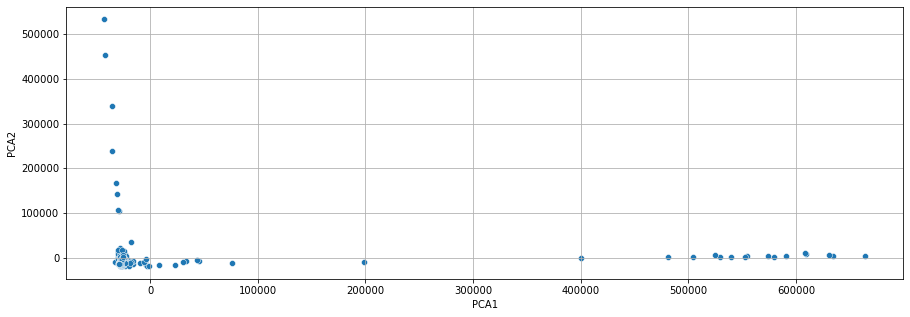

In [57]:
fig = plt.figure(figsize = (15,5))

sns.scatterplot(x = X[:,0],y = X[:,1])
plt.grid()
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

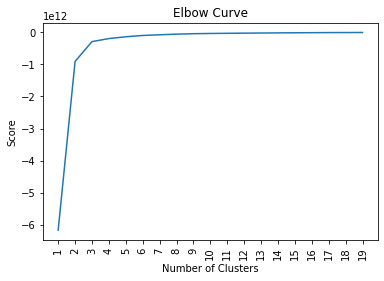

In [58]:
N_cluster = range(1, 20)
kmeans = [KMeans(n_clusters = i, random_state = 0) for i in N_cluster ]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
plt.plot(N_cluster, score)
plt.xticks(N_cluster, N_cluster, rotation ='vertical')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

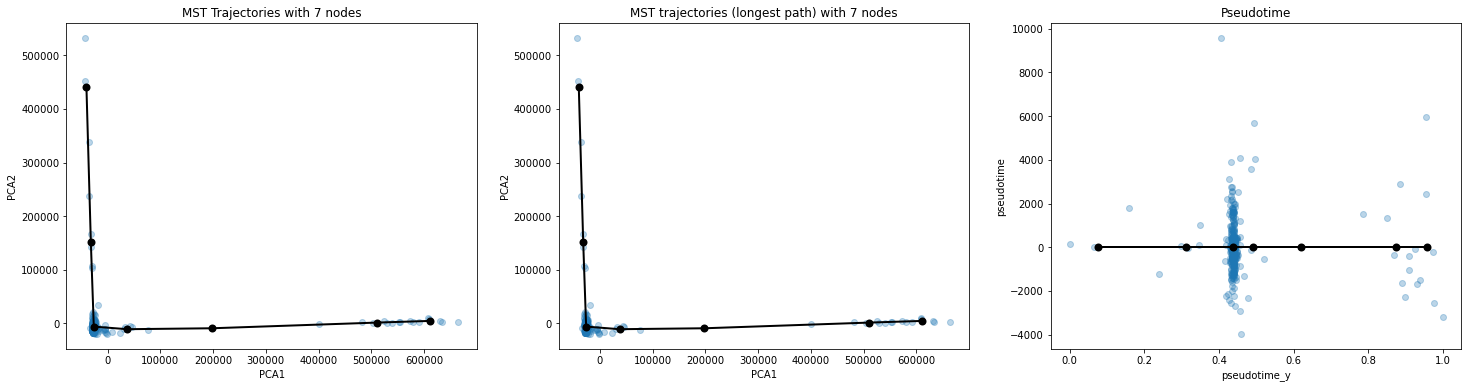

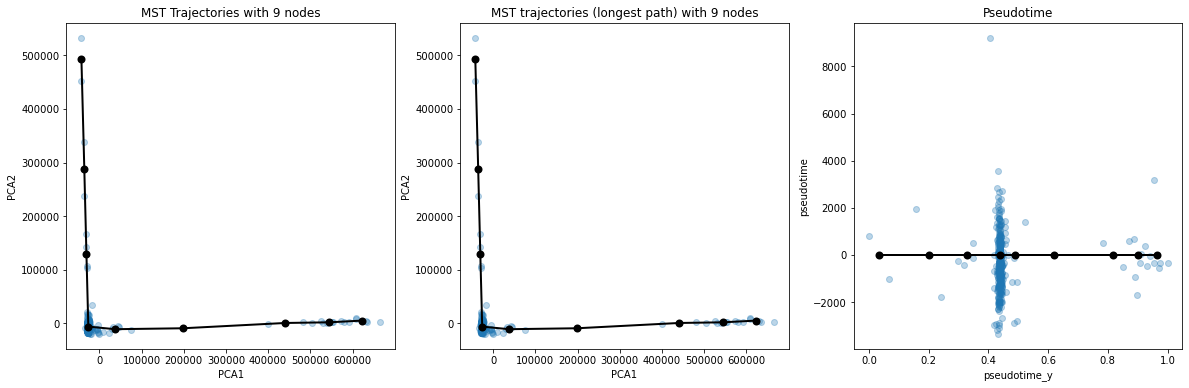

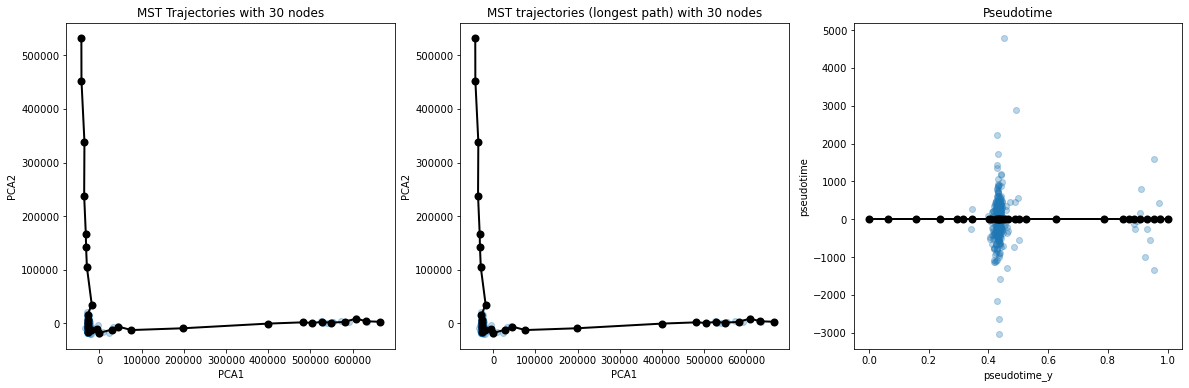

<Figure size 1440x432 with 0 Axes>

In [60]:
c = 0
fig = plt.figure(figsize = (25,6))
for n_clusters in [7, 9, 30]:
    dict_result = create_tree(X, n_clusters = n_clusters)
    edges = dict_result['edges_mst']
    edges_long = dict_result['edges_long']
    nodes_positions = dict_result['nodes_positions']
    
    c += 1
    fig.add_subplot(1,3,c)
    plot_graph(edges, nodes_positions, data = X)
    plt.title('MST Trajectories with '+ str(n_clusters) + ' nodes' )
    
    c += 1
    fig.add_subplot(1,3,c)
    plot_graph(edges_long, nodes_positions, data = X)
    plt.title('MST trajectories (longest path) with '+ str(n_clusters) + ' nodes' )

    c += 1
    fig.add_subplot(1, 3, c) 
    pseudotime(edges_long, nodes_positions, X)
    plt.title('Pseudotime') 
    
    if c%3 == 0:
        plt.show()
        fig = plt.figure(figsize = (20,6) )
        c = 0  

## Dumbell like data

(600, 2) (600,)


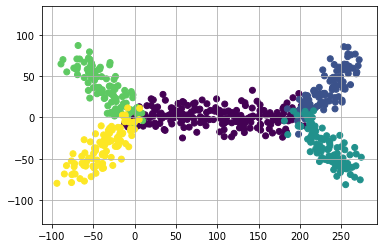

In [48]:
def make_dumbbell(n_layers = 1, n_features = 2,  sigma_noise = 10.0, n_samples4base = 200,
                  n_samples4branches = [100,100,100,100] , angles = [np.pi/4,-np.pi/4,3*np.pi/4,-3*np.pi/4] ):

    """
    n_layers = 2
    n_features = 2
    sigma_noise = 10.0
    plot_mode = 'PCA'
    n_samples4base = 200
    n_samples4branches = [100,100,100,100]
    angles = [np.pi/4,-np.pi/4,3*np.pi/4,-3*np.pi/4]
    """

    X_noiseless = np.zeros( (0,n_features))
    y_final = np.zeros( 0 )
    for layer in range(n_layers):
        current_label = 0 
        X = np.zeros( (n_samples4base, n_features) )
        X[:,0] = np.arange(n_samples4base)
        y = current_label * np.ones( n_samples4base )
        v_last_base_point_save = X[-1,:].copy()
        v_first_base_point_save = X[0,:].copy()

        # Make branches
        n_branches = len ( n_samples4branches )
        for c_branch in range( n_branches ) : # n_branches
            n_sample4branch = n_samples4branches[c_branch]
            current_label += 1
            y_branch = current_label * np.ones( n_sample4branch )
            angle = angles[c_branch] 
            if c_branch < n_branches/ 2:
                v_initial = v_last_base_point_save
            else:
                v_initial = v_first_base_point_save  
            X_branch = np.zeros( (n_sample4branch,  n_features)  ) #  [:2] = (np.cos(angle), np.sin(angle) )  
            v_direction = np.zeros( n_features)
            v_direction[0] = np.cos(angle)
            v_direction[1] = np.sin(angle)
            X_branch += v_direction # Broadcast vector to the whole array over axis 0 
            X_branch *= np.arange( 1, X_branch.shape[0] +1 ).reshape(X_branch.shape[0], 1 ) # Broadcast - mutiply each column by  by column = 1,2,3, ... 
            X_branch += v_initial # 
            X = np.concatenate( (X,X_branch) , axis = 0 )
            y = np.concatenate( (y, y_branch ))
        X_noiseless = np.concatenate( (X_noiseless,X) , axis = 0 )
        y_final = np.concatenate( (y_final,y) ) 
    
    X_noisy = X_noiseless + sigma_noise * np.random.randn( X_noiseless.shape[0], X_noiseless.shape[1] )


    y = y_final
    X = X_noisy

    if 0:
        print(X.shape, y.shape)
        r = X_noisy
        plt.scatter(r[:,0],r[:,1], c =y)
        plt.show()
  
    return X,y

X,y = make_dumbbell(n_layers = 1, n_features = 2,  sigma_noise = 10.0, n_samples4base = 200,
                  n_samples4branches = [100,100,100,100] , angles = [np.pi/4,-np.pi/4,3*np.pi/4,-3*np.pi/4] )
if 1:
    print(X.shape, y.shape)
    r = X
    plt.scatter(r[:,0],r[:,1], c =y)
    plt.axis("equal")
    plt.grid()
    plt.show()

In [45]:
X,y = make_dumbbell(n_layers = 1, n_features = 2,  sigma_noise = 10.0, n_samples4base = 200,
                  n_samples4branches = [100,100,100,100] , angles = [np.pi/4,-np.pi/4,3*np.pi/4,-3*np.pi/4] )

X = PCA().fit_transform(X)
X = X[:,:2]

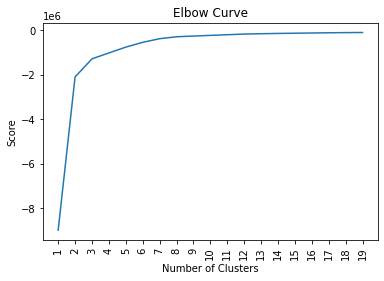

In [46]:
N_cluster = range(1, 20)
kmeans = [KMeans(n_clusters = i, random_state = 0) for i in N_cluster ]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
plt.plot(N_cluster, score)
plt.xticks(N_cluster, N_cluster, rotation ='vertical')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

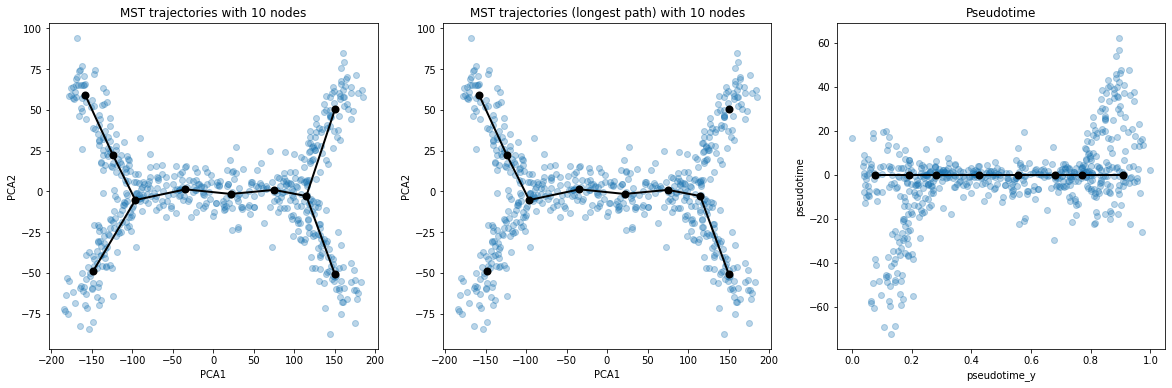

<Figure size 1440x432 with 0 Axes>

In [47]:
fig = plt.figure(figsize=(20, 6))
c = 0

dict_result = create_tree(X, n_clusters = 10)
edges = dict_result['edges_mst']
edges_long = dict_result['edges_long']
nodes_positions = dict_result['nodes_positions']

# print(nodes_positions)
# print(edges_long)

c += 1
fig.add_subplot(1, 3, c) 
plot_graph(edges, nodes_positions, data = X)
plt.title('MST trajectories with '+str(nodes_number)+' nodes')

c += 1
fig.add_subplot(1, 3, c) 
plot_graph(edges_long, nodes_positions, data = X,)
plt.title('MST trajectories (longest path) with '+str(nodes_number)+' nodes') 

c += 1
fig.add_subplot(1, 3, c) 
pseudotime(edges_long, nodes_positions, X)
plt.title('Pseudotime') 

if (c%3 == 0) :
    plt.show() 
    fig = plt.figure(figsize=(20, 6))
    c = 0 